## Full analysis of a sample tested positive to the sapovirus GI.1 during a non-foodborne outbreak in Miyagi-Japan
Individual H6 (s67)

This workflow is a modified version of the original iVar workflow. Sapovirus genome was amplified by PCR in duplicate and amplified products from Pool1 primers and Pool2 primers were obtained. Amplicons derived from replicate of same sample were pooled into a single tube. Illumina Nextera library was prepared and Amplicon sequencing was performed. 
Here, we will use paired reads from one sample. 
These were collected during a non-foodborne sapovirus outbreak. Let's start by aligning these reads to reference. The first step is creating an index to align the reads to. 

In [38]:
import os
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan/")

### 1-index reference for mapping

In [39]:
%%bash
echo "GANBATTE! KTE"
echo "reference indexed"

# index ref
bwa index MG012440_GI.2_ref.fa

GANBATTE! KTE
reference indexed


[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.00 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.12-r1039
[main] CMD: bwa index MG012440_GI.2_ref.fa
[main] Real time: 0.055 sec; CPU: 0.008 sec


### 2-Map reads to reference

In [40]:
%%bash
bwa mem -t 32  MG012440_GI.2_ref.fa  22_S5_L001_R1_001.fastq.gz 22_S5_L001_R2_001.fastq.gz | samtools view -b -F 4 -F 2048 | samtools sort -o 22_japan_GI.2_a.sorted.bam
echo "mapping completed"

mapping completed


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 2333598 sequences (320000052 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (36, 1123387, 33, 36)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (335, 1119, 2680)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 7370)
[M::mem_pestat] mean and std.dev: (1622.69, 1602.87)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 9715)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (81, 125, 188)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 402)
[M::mem_pestat] mean and std.dev: (140.26, 77.75)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 509)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (32, 911, 2832)
[M::mem_pestat] low an

In [41]:
%%bash
ls

22_japan_GI.2_a.sorted.bam
22_S5_L001_R1_001.fastq.gz
22_S5_L001_R2_001.fastq.gz
MG012440_GI.2.gff
MG012440_GI.2_ref.fa
MG012440_GI.2_ref.fa.amb
MG012440_GI.2_ref.fa.ann
MG012440_GI.2_ref.fa.bwt
MG012440_GI.2_ref.fa.pac
MG012440_GI.2_ref.fa.sa
Primalprimers_SaV_GI.2_batch2_ok.fa
Primal-primers_SaVGI.2pairs_ok.tsv
script-ivar-22_japan.sh


In [42]:
%%bash
samtools flagstat 22_japan_GI.2_a.sorted.bam

2720152 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
2720152 + 0 mapped (100.00% : N/A)
2720152 + 0 paired in sequencing
1360413 + 0 read1
1359739 + 0 read2
2701100 + 0 properly paired (99.30% : N/A)
2714032 + 0 with itself and mate mapped
6120 + 0 singletons (0.22% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


### 3-Let's now trim-off the primer sequences using ivar. 
In order to do this we need three files: (1) a BED file with primer coordinates. We will generate this by aligning the primer sequences to the reference sequence and then using bedtools to create the BED file. We also neet (2) Aligned and (3) sorted BAM file generate in the previous step.


In [43]:
# map primers to the reference genome to identify primers coordinates

In [44]:
%%bash
bwa mem -k 5 -T 16 MG012440_GI.2_ref.fa Primalprimers_SaV_GI.2_batch2_ok.fa  | samtools view -b -F 4 > Primalprimers_SaV_GI.2_batch2_ok.fa.bam
bedtools bamtobed -i Primalprimers_SaV_GI.2_batch2_ok.fa.bam > 22_japan_GI.2_primers.bed
echo "bed file with primers locations on reference sequence generated"

bed file with primers locations on reference sequence generated


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 68 sequences (1514 bp)...
[M::mem_process_seqs] Processed 68 reads in 0.012 CPU sec, 0.012 real sec
[main] Version: 0.7.12-r1039
[main] CMD: bwa mem -k 5 -T 16 MG012440_GI.2_ref.fa Primalprimers_SaV_GI.2_batch2_ok.fa
[main] Real time: 0.014 sec; CPU: 0.015 sec


In [45]:
# We will now use this BED file as input to ivar to trim primer sequences

# Note that this BED file has to be generated only once for a reference sequence.

In [46]:
%%bash
ivar trim -b 22_japan_GI.2_primers.bed -p 22_japan_GI.2.trimmed -i 22_japan_GI.2_a.sorted.bam
echo "primers trimming complete"

# Sort and index trimmed BAM file.
samtools sort -o 22_japan_GI.2.trimmed.sorted.bam 22_japan_GI.2.trimmed.bam ; samtools index 22_japan_GI.2.trimmed.sorted.bam
echo "Sorted and indexed trimmed BAM file"


Number of references: 1
Reference Name: MG012440
Reference Length: 7449
Using Region: MG012440
Sorted By Coordinate
Sorted By Query Name
Processed 1000000 reads ... 
Processed 2000000 reads ... 
Results: 
Trimmed primers from 704481 reads.
122008 reads were shortened below the minimum length of 30 bp and were not writen to file.
1939726 reads that started outside of primer regions were not written to file.
primers trimming complete
Sorted and indexed trimmed BAM file


[E::idx_find_and_load] Could not retrieve index file for '22_japan_GI.2_a.sorted.bam'


In [47]:
%%bash
samtools flagstat 22_japan_GI.2.trimmed.sorted.bam

658418 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
658418 + 0 mapped (100.00% : N/A)
658418 + 0 paired in sequencing
342317 + 0 read1
316101 + 0 read2
655083 + 0 properly paired (99.49% : N/A)
657707 + 0 with itself and mate mapped
711 + 0 singletons (0.11% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


### 4-Let's quicky take a look at the depth of the trimmed vs untrimmed BAM file. We'll extract the depth using the samtools depth command.


In [48]:
%%bash
mkdir depth
samtools depth -a 22_japan_GI.2.trimmed.sorted.bam > depth/22_japan_GI.2.trimmed.sorted.bam.depth ; samtools depth -a 22_japan_GI.2_a.sorted.bam > depth/22_japan_GI.2.sorted.bam.depth
echo "Please plot the depth per position"

Please plot the depth per position


In [49]:
## Plot of the depth per position

In [50]:
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan/depth")

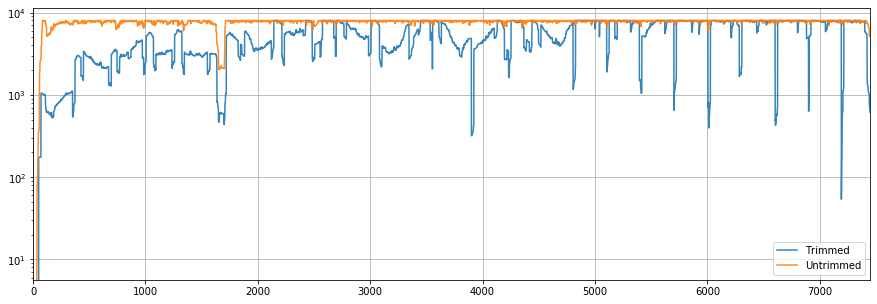

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
df_trimmed = pd.read_csv("22_japan_GI.2.trimmed.sorted.bam.depth", sep = "\t", names = ["Ref", "Pos", "depth_t"])
df_untrimmed = pd.read_csv("22_japan_GI.2.sorted.bam.depth", sep = "\t", names = ["Ref", "Pos", "depth_unt"])

ax = df_trimmed["depth_t"].plot(logy=True, label = "Trimmed", figsize = (15,5), alpha = 0.9)
df_untrimmed["depth_unt"].plot(logy=True, ax = ax, label ="Untrimmed", alpha=0.9)
plt.legend()
plt.grid()
plt.show()

In [52]:
# there has clearly been a decrease of number of reads

### 5-Let us identify primer sequences that might have a mismatch with the consensus sequence to ensure that we remove reads from any amplicons derived from those primers; Otherwise, it might bias the iSNV frequency due to varying primer binding effeciency

In [53]:
#To that end, we have to : 

#Call consensus on merged BAM file (If the sequencing of each technical replicate was done separately).

#Align primer sequences to consensus after creating a bwa index from the consensus sequence called.

In [54]:
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan/")

In [55]:
%%bash
# a-call consensus
samtools mpileup -A -d 0 -Q 0 22_japan_GI.2.trimmed.sorted.bam  | ivar consensus -p 22_japan_GI.2.consensus
echo "consensus called on BAM file."

Minimum Quality: 20
Threshold: 0
Minimum depth:  
Regions with depth less than minimum depth covered by: -
consensus called on BAM file.


[mpileup] 1 samples in 1 input files
[mpileup] Max depth set to maximum value (2147483647)


In [56]:
%%bash
# Map primers to the indexed consensus sequence
bwa index -p 22_japan_GI.1.consensus 22_japan_GI.2.consensus.fa
bwa mem -k 5 -T 16 22_japan_GI.1.consensus Primalprimers_SaV_GI.2_batch2_ok.fa  | samtools view -bS -F 4 | samtools sort -o 22_japan_GI.1_primers_consensus.bam

echo "primers mapped to consensus"

primers mapped to consensus


[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.00 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.12-r1039
[main] CMD: bwa index -p 22_japan_GI.1.consensus 22_japan_GI.2.consensus.fa
[main] Real time: 0.222 sec; CPU: 0.008 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 68 sequences (1514 bp)...
[M::mem_process_seqs] Processed 68 reads in 0.011 CPU sec, 0.011 real sec
[main] Version: 0.7.12-r1039
[main] CMD: bwa mem -k 5 -T 16 22_japan_GI.1.consensus Primalprimers_SaV_GI.2_batch2_ok.fa
[main] Real time: 0.013 sec; CPU: 0.014 sec


In [57]:
%%bash
# "Let's now call iSNVs on this BAM file at a minimum threshold of 3% and the default minimum quality threshold of 20"
samtools mpileup -A -d 0  -Q 0 22_japan_GI.1_primers_consensus.bam | ivar variants -p 22_japan_GI.1_primers_consensus_1 -t 0.03 -r 22_japan_GI.2.consensus.fa -g MG012440_GI.2.gff

echo "iSNVs on this initial BAM (without removal of reads from mismached primers) called at a minimum threshold of 3%"


iSNVs on this initial BAM (without removal of reads from mismached primers) called at a minimum threshold of 3%


[mpileup] 1 samples in 1 input files
[mpileup] Max depth set to maximum value (2147483647)


In [58]:
%%bash
# Let's now get the indices of primers with mismtaches and their respective pairs. To get the pair information, we need a tsv file with two columns to represent the pairs of primers. This file is at pair_information.tsv
bedtools bamtobed -i 22_japan_GI.1_primers_consensus.bam > 22_japan_GI.1_primers_consensus.bam.bed ; ivar getmasked -i 22_japan_GI.1_primers_consensus_1.tsv -b 22_japan_GI.1_primers_consensus.bam.bed -f Primal-primers_SaVGI.1pairs_ok.tsv -p primer_mismatchers_indices
echo "you got the indices of primers with mismtaches and their respective pairs"


KTESAVG12_1_RIGHT	GI24thbatch_2_LEFT	GI24thbatch_1_RIGHT	KTESAVG12_5_RIGHT	KTESAVG12_7_LEFT	KTESAVG12_9_LEFT	KTESAVG12_11_LEFT	KTESAVG12_13_LEFT	KTESAVG12_16_LEFT	KTESAVG12_15_RIGHT	GI24thbatch_6_RIGHT	GI24thbatch_8_LEFT	KTESAVG12_21_LEFT	KTESAVG12_22_LEFT	KTESAVG12_25_LEFT	GI24thbatch_9_RIGHT
you got the indices of primers with mismtaches and their respective pairs


### 6- Let's omit reads from mismatched primers (Masking)

In [59]:
%%bash
ivar removereads -i 22_japan_GI.2.trimmed.sorted.bam -p 22_japan_GI.2.bad_are_masked.bam -t primer_mismatchers_indices.txt -b 22_japan_GI.2_primers.bed
echo "you removed reads from mismatched primers"

Writing to 22_japan_GI.2.bad_are_masked.bam
Number of references: 1
Reference Name: MG012440
Reference Length: 7449
Using Region: MG012440
Sorted By Coordinate
Results:
155369 reads were removed.
you removed reads from mismatched primers


In [60]:
%%bash
samtools flagstat 22_japan_GI.2.bad_are_masked.bam

503049 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
503049 + 0 mapped (100.00% : N/A)
503049 + 0 paired in sequencing
261720 + 0 read1
241329 + 0 read2
500496 + 0 properly paired (99.49% : N/A)
502499 + 0 with itself and mate mapped
550 + 0 singletons (0.11% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [61]:
%%bash
# let us take a look at the reads distribution before and after masking
samtools sort -o 22_japan_GI.2.bad_are_masked.sorted.bam 22_japan_GI.2.bad_are_masked.bam 
samtools depth -a 22_japan_GI.2.bad_are_masked.sorted.bam > depth/22_japan_GI.2.bad_are_masked.sorted.depth

# echo "Let's now call iSNVs from the BAMS without reads from the masked amplicons"

samtools mpileup -A -d 0 --reference MG012440_GI.2_ref.fa -Q 0 22_japan_GI.2.bad_are_masked.sorted.bam | ivar variants -p 22_japan_GI.2_final -t 0.03 -r MG012440_GI.2_ref.fa -g MG012440_GI.2.gff ; echo "analysis is completed"
echo "please exclude variants with depth <400 and count iSNV"

analysis is completed
please exclude variants with depth <400 and count iSNV


[mpileup] 1 samples in 1 input files
[mpileup] Max depth set to maximum value (2147483647)


In [62]:
# Let's plot the distribution of masked and unmasked reads
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan/depth")

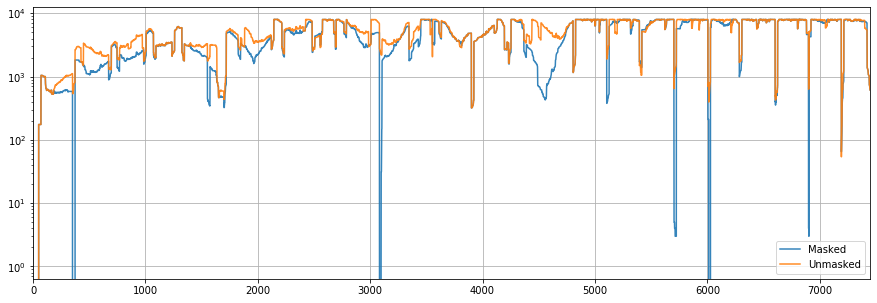

In [63]:

import pandas as pd
import matplotlib.pyplot as plt
df_unmasked = pd.read_csv("22_japan_GI.2.trimmed.sorted.bam.depth", sep = "\t", names = ["Ref", "Pos", "depth_unmask"])
df_masked = pd.read_csv("22_japan_GI.2.bad_are_masked.sorted.depth", sep = "\t", names = ["Ref", "Pos", "depth_mask"])

ax = df_masked["depth_mask"].plot(logy=True, label = "Masked", figsize = (15,5), alpha = 0.9)
df_unmasked["depth_unmask"].plot(logy=True, ax = ax, label ="Unmasked", alpha=0.9)
plt.legend()
plt.grid()
plt.show()

#### 7- View Tables and Plots

In [64]:
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan/")

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
rep_a = pd.read_csv("22_japan_GI.2_final.tsv", sep="\t")
rep_a["S_NS"] = np.where(rep_a["REF_AA"] == rep_a["ALT_AA"], "S", "NS")
rep_a.head()

,REGION,POS,REF,ALT,REF_DP,REF_RV,REF_QUAL,ALT_DP,ALT_RV,ALT_QUAL,ALT_FREQ,TOTAL_DP,PVAL,PASS,GFF_FEATURE,REF_CODON,REF_AA,ALT_CODON,ALT_AA,S_NS
0,MG012440,418,C,T,0,0,0,1687,0,38,0.999408,1688,0.000000e+00,True,NaN,GTC,V,GTT,V,S
1,MG012440,427,C,T,2,0,39,1685,3,38,0.998814,1687,0.000000e+00,True,NaN,ATC,I,ATT,I,S
2,MG012440,481,C,T,0,0,0,1083,220,38,1.000000,1083,0.000000e+00,True,NaN,GAC,D,GAT,D,S
3,MG012440,871,C,G,0,0,0,1771,783,39,1.000000,1771,0.000000e+00,True,NaN,CGC,R,CGG,R,S
4,MG012440,979,C,T,2149,2042,37,303,292,34,0.123573,2452,6.962400e-96,True,NaN,GGC,G,GGT,G,S


In [66]:
rep_b=rep_a[rep_a['TOTAL_DP'] >= 400]
shape = rep_b.shape 
shape

(47, 20)

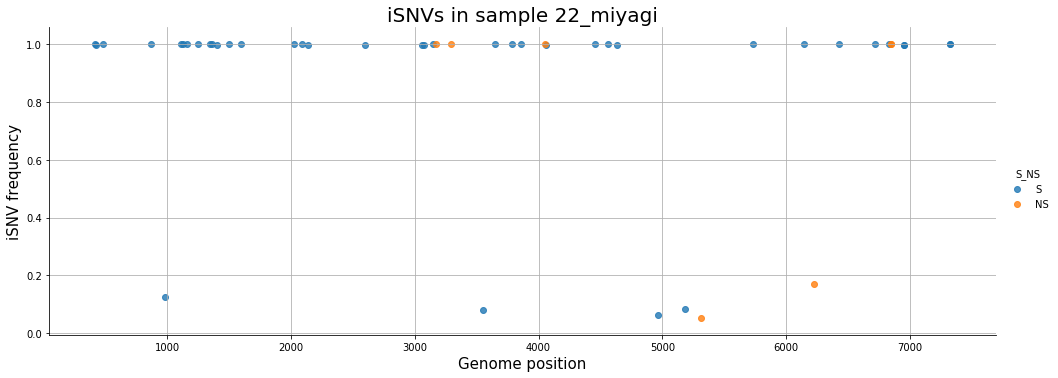

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
rep_b=rep_a[rep_a['TOTAL_DP'] >= 400]
sns.lmplot( x="POS", y="ALT_FREQ", data=rep_b, fit_reg=False, hue='S_NS',aspect=14/5, 
           legend=True, legend_out=True)
plt.xlabel('Genome position', fontsize=15)
plt.ylabel('iSNV frequency', fontsize=15)
plt.title('iSNVs in sample 22_miyagi', fontsize=20)
plt.grid(axis="both")
plt.show()

In [68]:
# let us filter snps in non structural region [1-5099]
print("snps in non structural region")
print((rep_b[(rep_b['POS'] > 3610) & (rep_b['POS'] < 5099)]).shape)
# let us filter snps in complete capsid[5010-6800]
print("snps in capsid")
print((rep_b[(rep_b['POS'] > 5100) & (rep_b['POS'] < 7350)]).shape)

snps in non structural region
(9, 20)
snps in capsid
(14, 20)


In [69]:
# what percentage of this masked genome (without reads from mismached primers) has depth >400 ? 
os.chdir("/media/viro102/HD-ADU3/kte-data/sapo-ivar/test/outbreak_samples/GI.2/22_japan/depth")
df_masked = pd.read_csv("22_japan_GI.2.bad_are_masked.sorted.depth", sep = "\t", names = ["Ref", "Pos", "depth_mask"])
df_masked['400cov'] = np.where(df_masked['depth_mask']>=400, 'yes', 'no')
df_masked['100cov'] = np.where(df_masked['depth_mask']>=100, 'yes', 'no')
df_masked.head()

,Ref,Pos,depth_mask,400cov,100cov
0,MG012440,1,0,no,no
1,MG012440,2,0,no,no
2,MG012440,3,0,no,no
3,MG012440,4,0,no,no
4,MG012440,5,0,no,no


In [70]:
# What proportion of the genome is has a depth of coverage of at least >100 reads, >400 (Breadth ofcoverage)
my_tab1 = pd.crosstab(index=df_masked["100cov"],  # Make a crosstab
                              columns="Breadth 100coverage")      # Name the count column
my_tab2 = pd.crosstab(index=df_masked["400cov"],  # Make a crosstab
                              columns="Beadth above 400coverage")      # Name the count column
shape=df_masked.shape
print(shape)
print(my_tab1); print(my_tab2)

(7449, 5)
col_0   Breadth 100coverage
100cov                     
no                      135
yes                    7314
col_0   Beadth above 400coverage
400cov                          
no                           217
yes                         7232


In [71]:
7232/7449 * 100 # proportion of genome covered >400

97.08685729628138

In [72]:
7316/7449 * 100 # proportion of genome covered >100

98.21452543965633